In [1]:
"""
Tensorflowによるオートエンコーダの実装
思い出しがてらの作成なのでコメントが膨大…
"""


#%%
# cording = UTF-8
import os
import re
import random
import copy
import scipy
import librosa #無くしたい
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import keras
import tensorflow

####################################初期化####################################
aug_amount = 100    #ファイルごとのAugmentationの回数
lr = 1e-01          #初期学習率
alpha = 1e-03       #L2正則化の係数
dr_rate = 0.3       #ドロップアウト率
batch_size = 50
epochs = 100
encode_dim = 1000   #オートエンコーダの圧縮次元

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(data_dir,"OK")
ng_dir = os.path.join(data_dir,"NG")
env_dir = os.path.join(data_dir,"environment")

#学習用データファイル
datafile = "dataset2.npz"

####################################関数定義###################################

#対象ディレクトリのファイル一覧を取得
def get_file_list(dir):
    path = dir
    file_list = os.listdir(path)
    print("get file_list :{}".format(file_list))
    return file_list

#対象ディレクトリの最大ファイルをサーチ
def wav_search(dir,f_list):
    #呼び出されるごとに初期化する
    wave_list = []
    file_size = 0
    
    return_path = os.path.abspath('./')
    
    os.chdir(dir)
    for i in f_list:
        search_index = re.search('.wav',i)
        if search_index:
            wave_list .append(i)
            if os.path.getsize(i) > file_size:
                file_size = os.path.getsize(i)
                largest_file = i
        
    os.chdir(return_path)   #カレントディレクトリを戻す
    print("get file :{0} ,file size:{1}"\
        .format(largest_file,file_size))
    return wave_list,largest_file,file_size

#オーディオファイルの読み込み サンプルレート22.05kHz、モノラルで固定
def load_wav(dir,file):
    #呼び出されるごとに初期化する
    wf = np.arange(0)

    f_path = os.path.join(dir,file)
    wf,sp_rate = librosa.load(f_path,sr=22050,mono = True)
    del sp_rate
    return wf

#スペクトログラムの取得 パワースペクトラムのまま処理するならlibrosa不要
def get_spg(wf):
    spg = np.arange(0)
    sp_f,sp_t,spg = scipy.signal.spectrogram(wf,fs=22050,
        window = np.hamming(1024),nfft =1024)
    spg = librosa.power_to_db(spg)
    spg =spg.astype('float16')
    return sp_f,sp_t,spg

#Augmentationの処理
def aug_process(frame,dir,wave_list,env_file,):
    #呼び出されるごとに初期化する
    length = 0
    count = 0
    wf = np.arange(0)

    length = int(frame * 1.2)
    for i in wave_list:
        wf = load_wav(dir,i)
        for j in range(aug_amount):
            start = random.randint(0,len(env_file)-length)
            aug_wav = copy.deepcopy(env_file[start : start + length])
            del start
            start = random.randint(0,len(aug_wav) - len(wf))
            aug_wav = aug_wav + random.gauss(1,0.05)
            aug_wav[ start:start + len(wf) ] = \
                aug_wav[ start : start + len(wf) ] + wf
            sp_f,sp_t,spg = get_spg(aug_wav)
            spg = spg.reshape(1,len(sp_f),len(sp_t))
            try:
                X_data
            except:
                X_data = copy.deepcopy(spg)
            else:
                X_data = np.vstack((X_data,spg))
            del start,aug_wav,sp_f,sp_t,spg
            count = count + 1
        del wf
        print("Augmentation done! total count = {}".format(count))

    return X_data

#データセットの作成 ここまでの関数は全部ここに集約される
#最大ファイルサイズに合わせてフレームサイズを定義し
#OK・NG各データセットを作成後、結合する

def new_dataset(aug,ok_dir,ng_dir,env_dir):
    #OKNGそれぞれのファイルリストと最大ファイルを取得
    ok_filelist = get_file_list(ok_dir)
    ok_wave_list,ok_largeest_name,ok_largest_size = wav_search(ok_dir,ok_filelist)
    ng_filelist = get_file_list(ng_dir)
    ng_wave_list,ng_largeest_name,ng_largest_size = wav_search(ng_dir,ng_filelist)

    #OKNGの最大を比較
    if ok_largest_size>ng_largest_size:
        largest_dir = ok_dir
        lergest_name = ok_largeest_name
        print("largetst:OK")
    else:
        largest_dir = ng_dir
        lergest_name = ng_largeest_name
        print("largetst:NG")

    #最大フレームサイズを取得
    wf = load_wav(largest_dir,lergest_name)
    frame = int(len(wf))
    #wf = np.insert(wf,frame,np.empty(int(frame*0.2))) #1.2倍する
    #sp_f,sp_t,spg = get_spg(wf) 
    #X_initsize = (len(sp_f),len(sp_t))
    #del wf,sp_f,sp_t,spg
    del wf

    #環境音データをロード
    env_data = load_wav(env_dir,"env.wav")
    
    #OKデータセット作成
    X_ok = copy.deepcopy(
        aug_process(frame,ok_dir,ok_wave_list,env_data)
        )
    y_ok = np.zeros(len(X_ok),dtype = 'bool')

    #NGデータセット作成
    X_ng = copy.deepcopy(
        aug_process(frame,ng_dir,ng_wave_list,env_data)
        )
    y_ng = np.ones(len(X_ng),dtype = 'bool')

    #データセットの結合
    X_data = np.vstack((X_ok,X_ng))
    y_data = np.append(y_ok,y_ng)
    del X_ok,y_ok,X_ng,y_ng

    return X_data,y_data

#OKNGが混在したデータからFalseのみを分離する
def mixed_to_sprit(X_mixed,y_mixed):
    #呼び出されるごとに初期化する
    try:
        X_sprit
    except:
        pass    #X_spritが存在しなければ何もしない
    else:
        del X_sprit #前のデータを消去する

    for i in range(len(X_mixed)):
        if y_mixed[i] == False:
            try:
                X_sprit
            except: #X_spritを生成する
                X_sprit = copy.deepcopy(X_mixed[i])
                X_sprit = X_sprit.reshape(1,X_mixed.shape[1])
            else:   #既存のX_spritに追加する 前段の例外処理はここを避けるため
                X_sprit = np.vstack(
                    (X_sprit,X_mixed[i].reshape(1,X_mixed.shape[1]))
                    )

    return X_sprit

###################################メイン処理###################################

#データセット読み込み なければ作る
if os.path.exists(os.path.join(data_dir,datafile)) == False:
    X_data,y_data = new_dataset(aug_amount,ok_dir,ng_dir,env_dir)
    np.savez_compressed(os.path.join(data_dir,datafile),
        X = X_data,y = y_data)
    print("Data set saved!") #ファイルネーム表示機能つけること
else:
    load_data = np.load(os.path.join(data_dir,datafile))
    X_data =load_data['X']
    y_data = load_data['y']
    del load_data
    print("Data loaded!!")

#データ前処理 trainとtestを分離
from sklearn.model_selection import train_test_split
X_shape = X_data.shape[1:]
X_data = X_data.reshape(len(X_data),-1) #アフィン変換
X_train,X_test,y_train,y_test = \
    train_test_split(X_data,y_data,test_size=0.05)
print(
"Training data amounts :{0}\n\
Test data amounts :{1}"\
.format(len(y_train),len(y_test))
)
del X_data,y_data


Using TensorFlow backend.
Data loaded!!
Training data amounts :3800
Test data amounts :200


In [2]:
#X_trainからOKデータ(False)だけを抽出する

X_train_ae = mixed_to_sprit(X_train,y_train)
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)

#スケーラを定義する(AEの出力にシグモイドを使うため)
scaler = sklearn.preprocessing.MinMaxScaler()


X_train for Autoencoder was splited!!
amount/shape:(1888, 60021)


In [3]:
#オートエンコーダの定義

from keras.models import Model,Sequential
from keras.layers import Input, Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from keras import regularizers

#Modelでの実装 もう少しわかりやすい形にする
def ae(input_dim,encode_dim,lr,alpha,dr_rate):

    input_data = Input(shape = (input_dim,))

    #エンコーダを定義
    encoder = Dense(
        encode_dim,
        kernel_initializer="he_normal",
        kernel_regularizer=regularizers.l2(alpha),
        )(input_data)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(dr_rate)(encoder)
    encoder = Activation("relu")(encoder)

    #デコーダを定義 こっちにはドロップアウトは定義しない
    decoder = Dense(input_dim,kernel_initializer="he_normal")(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation("sigmoid")(decoder)

    #モデルを定義
    autoencoder = Model(input = input_data,output = decoder)

    #最適化関数 Nadamをデフォルトパラメタで使う
    opt = keras.optimizers.nadam(lr = lr)

    autoencoder.compile(
        optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
        )

    return autoencoder


In [4]:
# グリッドサーチ用コード

# パラメータ空間の定義
def gs_param():
    pm = {
        'alpha' : [1,1e-03,1e-06,1e-09],
        'lr':[1,1e-03,1e-06,1e-09],
        'dr_rate':[0,0.2],
        'batch_size':[50],
        'epochs':[10]
    }
    return pm

#SklearnでラップしたAEを生成
from keras.wrappers.scikit_learn import KerasClassifier
ae_sklearn = KerasClassifier(
    build_fn = ae,
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = lr,
    alpha = alpha,
    dr_rate = dr_rate
)

#グリッドサーチ
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    estimator = ae_sklearn,
    param_grid = gs_param(),
    return_train_score = True,
    cv = 3,
    verbose = 2 
)
X_train_ae = scaler.fit_transform(X_train_ae)   #スケール変換
grid.fit(X_train_ae,X_train_ae)

print('Gridsearch is over!')
print("Best parameters :{}".format(grid.best_params_))
print("Best cross-validation score :{}".format(grid.best_score_))
print("Accuracy of test sets : {}".format(grid.score(X_test,y_test)))


58 [==============================] - 74s 58ms/step - loss: 0.8060 - accuracy: 0.0176
Epoch 10/10
1258/1258 [==============================] - 9s 7ms/step
[CV]  alpha=1e-09, batch_size=50, dr_rate=0, epochs=10, lr=1e-09, total=12.5min
[CV] alpha=1e-09, batch_size=50, dr_rate=0, epochs=10, lr=1e-09 ......
Epoch 1/10
1259/1259 [==============================] - 74s 59ms/step - loss: 0.8061 - accuracy: 0.0175
Epoch 2/10
1259/1259 [==============================] - 73s 58ms/step - loss: 0.8061 - accuracy: 0.0175
Epoch 3/10
1259/1259 [==============================] - 73s 58ms/step - loss: 0.8061 - accuracy: 0.0175
Epoch 4/10
1259/1259 [==============================] - 74s 59ms/step - loss: 0.8061 - accuracy: 0.0175
Epoch 5/10
1259/1259 [==============================] - 73s 58ms/step - loss: 0.8061 - accuracy: 0.0175
Epoch 6/10
1259/1259 [==============================] - 73s 58ms/step - loss: 0.8061 - accuracy: 0.0175
Epoch 7/10
1259/1259 [==============================] - 73s 58ms/step 

ValueError: Error when checking target: expected activation_194 to have shape (60021,) but got array with shape (1,)

In [5]:
#サーチ結果を変数に格納
results =np.array(grid.cv_results_)

In [8]:
#データフレームに格納
import pandas as pd
results = pd.DataFrame(grid.cv_results_)

In [9]:
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_batch_size,param_dr_rate,param_epochs,param_lr,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,792.432458,18.089429,5.606254,0.297754,1,50,0,10,1,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0, '...",...,0.596302,0.754760,0.624530,0.096887,3,0.522751,0.596384,0.754754,0.624630,0.096798
1,771.927819,20.788122,5.547789,0.119289,1,50,0,10,0.001,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0, '...",...,0.824133,0.263900,0.514378,0.232523,13,0.455178,0.824519,0.264315,0.514670,0.232539
2,764.334815,5.878148,5.345135,0.039965,1,50,0,10,1e-06,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0, '...",...,0.503033,0.501335,0.502330,0.000723,15,0.502297,0.503400,0.501384,0.502360,0.000824
3,747.930233,3.833734,5.767556,0.466483,1,50,0,10,1e-09,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0, '...",...,0.500541,0.499213,0.499893,0.000543,21,0.499800,0.500426,0.499299,0.499842,0.000461
4,739.184909,6.913454,5.291005,0.029638,1,50,0.2,10,1,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0.2,...",...,0.729882,0.627849,0.678370,0.041661,1,0.677883,0.729252,0.627807,0.678314,0.041416
5,744.093635,0.382836,5.364922,0.022818,1,50,0.2,10,0.001,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0.2,...",...,0.906486,0.262694,0.674903,0.292218,2,0.855691,0.905473,0.261649,0.674271,0.292475
6,748.059180,2.389504,5.541120,0.313806,1,50,0.2,10,1e-06,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0.2,...",...,0.500961,0.501189,0.501134,0.000125,16,0.501338,0.501000,0.501329,0.501222,0.000157
7,747.258420,0.208828,6.029273,0.483345,1,50,0.2,10,1e-09,"{'alpha': 1, 'batch_size': 50, 'dr_rate': 0.2,...",...,0.499932,0.498805,0.499232,0.000498,25,0.499303,0.500056,0.498707,0.499355,0.000552
8,752.083831,1.383886,5.752952,0.373637,0.001,50,0,10,1,"{'alpha': 0.001, 'batch_size': 50, 'dr_rate': ...",...,0.414751,0.561140,0.442487,0.087776,30,0.351939,0.413805,0.561054,0.442266,0.087711
9,748.449097,3.647968,5.898106,0.701384,0.001,50,0,10,0.001,"{'alpha': 0.001, 'batch_size': 50, 'dr_rate': ...",...,0.488338,0.490175,0.417454,0.101547,31,0.274056,0.488558,0.490671,0.417761,0.101619


In [10]:
#結果をnparrayで書き出す
npresult = np.array(grid.cv_results_['mean_test_score']).reshape(4,2,4)

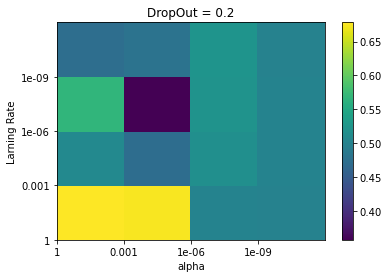

In [27]:
#Dropout = 0.2の時のヒートマップを描画
pm = gs_param()
plt.pcolormesh(npresult[:,1])
plt.title('DropOut = 0.2')
plt.xlabel("alpha")
plt.xticks(np.arange(len(pm['alpha'])),pm['alpha'])
plt.ylabel("Larning Rate")
plt.yticks(np.arange(len(pm['lr'])),pm['lr'])
plt.colorbar()
plt.show()

lrとalphaの軸が逆であることに注意
alphaは1～0.01、lrは0.001～1e-06あたりが適切なレンジと思われる